In [24]:
import pandas as pd
from statsmodels.gam.api import GLMGam, BSplines
import numpy as np

df = pd.read_csv(r'E:\MPA_project\MPA_merged.csv')
df.head()

,set_id,station,strata_strate,season_saison,total_count,tot_wt_g,shannon_index,species_richness,wet_weight,dry_weight,water_content_ratio,sand_pct,fine_sand_pct,silt_clay_pct,air_dry_wt,oven_dry_wt,loss_ash1,loss_ash2,tot_perc_loss__,depth_m_profondeur_m
0,2010.02.001,1,channel,Winter,23.500000,6407.0,1.710841,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.1
1,2010.02.002,2,channel,Winter,15.083333,6196.0,1.810717,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0
2,2010.02.003,3,channel,Winter,15.138889,4307.0,2.373054,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.5
3,2010.02.004,4,channel,Winter,18.375000,5947.0,2.156380,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5
4,2010.02.005,5,channel,Winter,29.650000,6531.0,2.203582,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.6


In [25]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print("\nNumber of duplicate rows:", duplicate_rows)

# Get summary statistics for numerical columns
summary_statistics = df.describe()
print("\nSummary statistics for numerical columns:\n", summary_statistics)

# Check data types of each column
data_types = df.dtypes
print("\nData types of each column:\n", data_types)

Missing values in each column:
 set_id                    0
station                   0
strata_strate             0
season_saison             0
total_count               0
tot_wt_g                  0
shannon_index             0
species_richness          0
wet_weight              124
dry_weight              124
water_content_ratio     124
sand_pct                124
fine_sand_pct           124
silt_clay_pct           124
air_dry_wt               62
oven_dry_wt              62
loss_ash1                62
loss_ash2                62
tot_perc_loss__          62
depth_m_profondeur_m     53
dtype: int64

Number of duplicate rows: 0

Summary statistics for numerical columns:
           station  total_count     tot_wt_g  shannon_index  species_richness  \
count  341.000000   341.000000   341.000000     341.000000        341.000000   
mean    15.208211    52.411318  3262.878299       1.587816         17.451613   
std      8.701287   125.218188  1739.610624       0.450819          7.000095   
mi

In [26]:
from sklearn.model_selection import train_test_split

# Assuming 'df' is your dataframe and 'shannon_index' is the target variable)
X = df.drop(columns=['shannon_index', 'set_id', 'station', 'total_count', 'species_richness'])
y = df['shannon_index']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (272, 15)
X_test shape: (69, 15)


## Regression Tree and XGBoost

In [27]:
# Identify numeric columns
adjusted_numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Define transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
            ('scaler', StandardScaler())  # Scale the numeric features
        ]), adjusted_numeric_cols),
        ('cat', OneHotEncoder(sparse_output=True, handle_unknown='ignore'), categorical_cols),
    ],
    remainder='drop'  # Drop any features not specifically mentioned above
)

In [29]:
# Fit the preprocessor on training data and transform both train and test sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)  # Use transform() on test set (no fit)

In [30]:
# Get the feature names for the numeric columns and categorical columns
categorical_column_names = preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols)

In [31]:
# Combine numeric column names and categorical column names
all_column_names = adjusted_numeric_cols + list(categorical_column_names)

In [32]:
from scipy.sparse import csr_matrix

X_train_transformed_dense = csr_matrix(X_train_transformed).todense()
X_test_transformed_dense = csr_matrix(X_test_transformed).todense()

# Convert to DataFrame with readable column names
X_train_transformed_df = pd.DataFrame(X_train_transformed_dense, columns=all_column_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed_dense, columns=all_column_names)

# Display the first few rows to check
print(X_train_transformed_df.head())

   tot_wt_g  wet_weight  dry_weight  water_content_ratio      sand_pct  \
0 -1.303415    0.000000    0.000000        -2.148405e-16 -9.008966e-17   
1  1.971198    0.000000    0.000000        -2.148405e-16 -9.008966e-17   
2  0.125195   -0.746995   -0.652315        -6.356860e-01 -4.205401e-01   
3 -1.596332    2.289149    3.282500         7.125277e-02  5.882708e+00   
4  0.589408    4.931458    3.568480         2.530364e+00 -4.518442e-01   

   fine_sand_pct  silt_clay_pct    air_dry_wt  oven_dry_wt  loss_ash1  \
0       0.000000       0.000000 -7.431249e-02     0.350710   0.505423   
1       0.000000       0.000000 -1.115985e-17     0.000000   0.000000   
2      -0.963801       0.929838 -1.115985e-17     0.000000   0.000000   
3      -1.334076      -4.334108 -7.388865e-02     1.424246   1.288903   
4      -1.001135       0.978911 -7.421797e-02     0.392087   1.763916   

      loss_ash2  tot_perc_loss__  depth_m_profondeur_m  strata_strate_channel  \
0  1.180610e+00         1.910057   

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

param_grid = {
    'max_depth': [15, 17, 20],
    'min_samples_split': list(range(2, 21)),
    'min_samples_leaf': list(range(1, 11)),
    'max_features': ['sqrt', 'log2']
}

# Initialize the regression tree model
model = DecisionTreeRegressor(random_state=42)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_transformed_df, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict on the training set
y_pred = best_model.predict(X_train_transformed_df)

# Evaluate the best model
mse = mean_squared_error(y_train, y_pred)
r2_value = r2_score(y_train, y_pred)

print("Best Hyperparameters:", best_params)
print("Training Performance:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2_value}")

Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2}
Training Performance:
Mean Squared Error (MSE): 0.1391083352087946
R-squared (R2): 0.293655184562043


In [34]:
# Predict on the test set
y_pred_test = best_model.predict(X_test_transformed_df)

# Evaluate the model performance on test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print('test')
print(f"Test Mean Squared Error (MSE): {mse_test}")
print(f"Test R-squared (R2): {r2_test}")

test
Test Mean Squared Error (MSE): 0.21588048403465687
Test R-squared (R2): 0.02363401609264848


In [35]:
from sklearn.tree import export_graphviz
import graphviz

# Export the tree in DOT format
dot_data = export_graphviz(best_model, out_file=None, 
                           feature_names=all_column_names, 
                           filled=True, rounded=True, 
                           special_characters=True)

# Create a graph from the DOT data
graph = graphviz.Source(dot_data)

# Save the graph as a PNG file
graph.render("regression_tree", format="png", cleanup=True)

'regression_tree.png'

In [36]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import shap

# Define hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

# Initialize the XGBoost model
model = xgb.XGBRegressor(random_state=42)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_transformed_df, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict on the training set
y_pred = best_model.predict(X_train_transformed_df)

# Evaluate the best model
mse = mean_squared_error(y_train, y_pred)
r2_value = r2_score(y_train, y_pred)

print("Best Hyperparameters:", best_params)
print("Training Performance:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2_value}")

Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.7}
Training Performance:
Mean Squared Error (MSE): 0.09146792406797755
R-squared (R2): 0.5355569898287154


In [37]:
# Predict on the test set
y_pred_test = best_model.predict(X_test_transformed_df)

# Evaluate the model performance on test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Test Mean Squared Error (MSE): {mse_test}")
print(f"Test R-squared (R2): {r2_test}")

Test Mean Squared Error (MSE): 0.17731876315873527
Test R-squared (R2): 0.19803770391343167


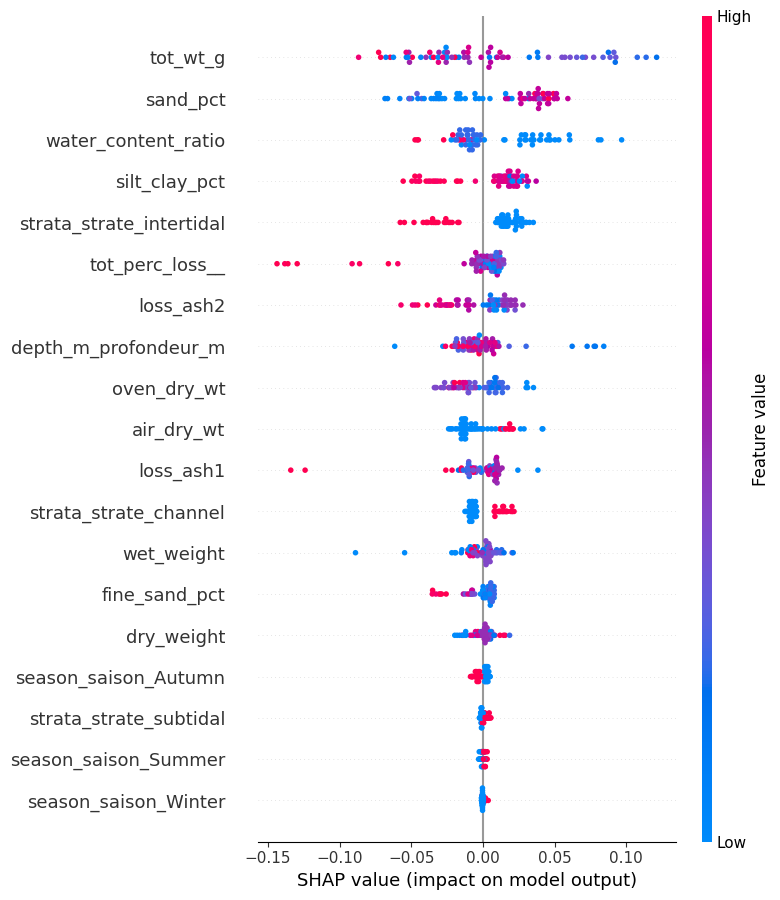

In [38]:
import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(best_model, X_train_transformed_df)

# Calculate SHAP values
shap_values = explainer(X_test_transformed_df)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test_transformed_df)